The task of the project is to predict Customers Lifetime Value on new customers. The CLV can be computed as:
```
CLV =  expected number of transactions x expected average transaction value
```



## Importing Libraries and installing packages

In [ ]:
! pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 KB 36.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure
import lifetimes
from lifetimes import BetaGeoFitter
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, median_absolute_error
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive

import warnings

warnings.filterwarnings('ignore')

We first open the json file:

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/raw_customer_data.json') as f:
    lines = f.readlines()

In [ ]:
# the first line looks like this :
lines[0]

'{"id": 128867, "transactions": [{"settledAt": "2022-03-10T14:14:34.583+0000", "ftd": true, "amount": 40.0, "status": "SUCCESS", "type": "deposit"}]}\n'

In [ ]:
len(lines) # the file has 6677 lines

6677

We will save the data into a pandas dataframe :

In [ ]:
# Empty lists for the data to be saved
id = []
settledAt = []
ftd = []
amount = []
status = []
Type = []

Error_rows = []


# Because we opened the json file as txt file, we have to go through each line of the file
for row in lines:
  try:

     Customers = pd.read_json(row)

  except ValueError: # some rows return a ValueError so we append the into the Error_rows list
                Error_rows.append(row)
                continue

  for dictionary in Customers['transactions']:
    try: # We have to confirm that each of these entries exist and if not a KeyError occurs
         ID = Customers['id'][0]
         SettledAt = dictionary['settledAt']
         FTD = dictionary['ftd']
         Amount = dictionary['amount']
         Status = dictionary['status']
         TYpe = dictionary['type']


    except KeyError: # some entries do not exist and the code returns a KeyError so we append the row into the Error_rows list
                Error_rows.append(row)
                continue

    # if the row does not return errors, we procede to append the data into the lists we created above
    id.append(Customers['id'][0])
    settledAt.append(dictionary['settledAt'])
    ftd.append(dictionary['ftd'])
    amount.append(dictionary['amount'])
    status.append(dictionary['status'])
    Type.append(dictionary['type'])


# Using the lists of data, we will save the data into a pandas dataframe for further processing and analysis
Customers_df = pd.DataFrame({'id' : id , 'settledAt' : settledAt , 'ftd' : ftd , 'amount' : amount , 'status' : status , 'type' : Type})
Customers_df

,id,settledAt,ftd,amount,status,type
0,128867,2022-03-10T14:14:34.583+0000,True,40.0,SUCCESS,deposit
1,128853,2022-03-10T11:30:45.292+0000,False,50.0,SUCCESS,deposit
2,128853,2022-03-10T09:55:57.469+0000,1.0,50.0,SUCCESS,deposit
3,128850,2022-03-10T11:06:32.510+0000,True,159.0,SUCCESS,deposit
4,128850,2022-03-10T11:32:38.318+0000,0.0,180.0,FAIL,deposit
...,...,...,...,...,...,...
180746,5825,2020-03-23T08:26:33.212+0000,0.0,20.0,CANCEL,deposit
180747,5825,2020-03-20T13:38:59.789+0000,0.0,25.0,FAIL,deposit
180748,5774,2019-12-15T20:09:26.286+0000,False,50.0,ERROR,withdrawal
180749,5774,2019-12-16T06:49:49.786+0000,0.0,50.0,SUCCESS,withdrawal


In [ ]:
print(f'{len(Error_rows)} rows return a Value error')

0 rows return a Value error


# Data Preprocessing :

As we can see, the column ftd except from true/false entries has also other values, 0 and 1, therefore, we will replace true/false values with 0 and 1 ( 0 if false and 1 if true) as programming languages understand numbers better than string.

In [ ]:
Customers_df= Customers_df.replace(to_replace= True , value=1)
Customers_df = Customers_df.replace(to_replace= False , value=0)
Customers_df

,id,settledAt,ftd,amount,status,type
0,128867,2022-03-10T14:14:34.583+0000,1,40.0,SUCCESS,deposit
1,128853,2022-03-10T11:30:45.292+0000,0,50.0,SUCCESS,deposit
2,128853,2022-03-10T09:55:57.469+0000,1,50.0,SUCCESS,deposit
3,128850,2022-03-10T11:06:32.510+0000,1,159.0,SUCCESS,deposit
4,128850,2022-03-10T11:32:38.318+0000,0,180.0,FAIL,deposit
...,...,...,...,...,...,...
180746,5825,2020-03-23T08:26:33.212+0000,0,20.0,CANCEL,deposit
180747,5825,2020-03-20T13:38:59.789+0000,0,25.0,FAIL,deposit
180748,5774,2019-12-15T20:09:26.286+0000,0,50.0,ERROR,withdrawal
180749,5774,2019-12-16T06:49:49.786+0000,0,50.0,SUCCESS,withdrawal


It is clear that the column 'settledAt' needs to be converted into DateTime.

Firstly, we will perform some NLP to the column 'settledAt' and then convert the column's type to DateTime. Moreover, the dataframe will be sorted from the latest settlement to the most recent one. Lastly, we will create two new columns named 'Month' and 'Year'.

Illustration of the NLP :

In [ ]:
settledAt[:5]

['2022-03-10T14:14:34.583+0000',
 '2022-03-10T11:30:45.292+0000',
 '2022-03-10T09:55:57.469+0000',
 '2022-03-10T11:06:32.510+0000',
 '2022-03-10T11:32:38.318+0000']

In [ ]:
for entry in settledAt[:5]:
  datetime = entry[:10] + ' ' + entry[11:]
  print(datetime)

2022-03-10 14:14:34.583+0000
2022-03-10 11:30:45.292+0000
2022-03-10 09:55:57.469+0000
2022-03-10 11:06:32.510+0000
2022-03-10 11:32:38.318+0000


In [ ]:
Datetime = []

for entry in settledAt:

  datetime = entry[:10] + ' ' + entry[11:]
  Datetime.append(datetime)


Customers_df['settledAt'] = Datetime
Customers_df.head()

,id,settledAt,ftd,amount,status,type
0,128867,2022-03-10 14:14:34.583+0000,1,40.0,SUCCESS,deposit
1,128853,2022-03-10 11:30:45.292+0000,0,50.0,SUCCESS,deposit
2,128853,2022-03-10 09:55:57.469+0000,1,50.0,SUCCESS,deposit
3,128850,2022-03-10 11:06:32.510+0000,1,159.0,SUCCESS,deposit
4,128850,2022-03-10 11:32:38.318+0000,0,180.0,FAIL,deposit


Checking whether data of the 'settledAt' column have the wrong format:

In [ ]:
# We will check if DateTime entries in column 'settledAt' follow a certain format, and if we will get the index of those false entries
from dateutil import parser
Index = []

for DateTime in Datetime:

    try:

     if bool(parser.parse(DateTime)) == True:
        continue


    except ValueError:
       index = Datetime.index(DateTime)
       Index.append(index)

print(f'The rows with the wrong datetime format have index: {Index}')

The rows with the wrong datetime format have index: []


It is clear that all data entries in the 'settledAt' column have the correct format

In [ ]:
Customers_df['settledAt'] =  pd.to_datetime( Customers_df['settledAt'] , format = '%Y-%m-%d %H:%M:%S.%f' ) # Converting data type to datetime

In [ ]:
Customers_df = Customers_df.sort_values(by=['id' , 'settledAt'], ignore_index=True)
Customers_df

,id,settledAt,ftd,amount,status,type
0,5774,2019-12-09 10:05:27.783000+00:00,1,50.0,SUCCESS,deposit
1,5774,2019-12-15 20:09:26.286000+00:00,0,50.0,ERROR,withdrawal
2,5774,2019-12-16 06:49:49.786000+00:00,0,50.0,SUCCESS,withdrawal
3,5825,2020-03-20 13:38:59.789000+00:00,0,25.0,FAIL,deposit
4,5825,2020-03-23 08:26:33.212000+00:00,0,20.0,CANCEL,deposit
...,...,...,...,...,...,...
180746,128853,2022-03-10 09:55:57.469000+00:00,1,50.0,SUCCESS,deposit
180747,128853,2022-03-10 11:30:45.292000+00:00,0,50.0,SUCCESS,deposit
180748,128853,2022-03-10 11:30:45.292000+00:00,0,50.0,SUCCESS,deposit
180749,128867,2022-03-10 14:14:34.583000+00:00,1,40.0,SUCCESS,deposit


We will go through each customer and delete any transactions that occurred before the first-time monetary transaction ( ftd = 1 ). If the dataframe has no indication about a customer's first-time monetary transaction, we will not delete any transaction data of that customer.

In [ ]:
# Firstly, we will check which customers have an indication of their ftd

FTD = pd.DataFrame.from_dict(dict(Customers_df[{'id' , 'ftd'}].groupby('id').sum())).sort_values(by = 'ftd')
FTD

,ftd
id,
5774,1
74099,1
74083,1
74056,1
74053,1
...,...
127146,2
103756,2
128853,2


As it can be seen, the dataframe contains more than one indication of a first-time monetary transaction of some consumers, thus we have to check if the rows are duplicated.

In [ ]:
duplicate = Customers_df[Customers_df.duplicated()]

print("Duplicate Rows :")
duplicate

Duplicate Rows :


,id,settledAt,ftd,amount,status,type
166920,103756,2021-10-12 10:53:18.339000+00:00,1,70.0,SUCCESS,deposit
166922,103756,2021-10-29 17:05:34.265000+00:00,0,20.0,FAIL,withdrawal
166924,103756,2021-11-04 12:38:58.093000+00:00,0,15.0,SUCCESS,withdrawal
166926,103756,2021-11-07 07:42:22.281000+00:00,0,20.0,CANCEL,deposit
166928,103756,2021-11-07 07:44:37.627000+00:00,0,20.0,SUCCESS,deposit
...,...,...,...,...,...,...
180742,128850,2022-03-10 11:06:32.510000+00:00,1,159.0,SUCCESS,deposit
180744,128850,2022-03-10 11:32:38.318000+00:00,0,180.0,FAIL,deposit
180746,128853,2022-03-10 09:55:57.469000+00:00,1,50.0,SUCCESS,deposit
180748,128853,2022-03-10 11:30:45.292000+00:00,0,50.0,SUCCESS,deposit


In [ ]:
# Drop duplicates:

Customers_df = Customers_df.drop_duplicates()

In [ ]:
# Check again for ftd

FTD = pd.DataFrame.from_dict(dict(Customers_df[{'id' , 'ftd'}].groupby('id').sum())).sort_values(by = 'ftd')
FTD

,ftd
id,
5774,1
74290,1
74272,1
74271,1
74267,1
...,...
37455,1
37454,1
37449,1


After dropping the duplicated rows, it is clear that all customers have one indication of their first-time monetary transaction.

In [ ]:
#checking for NaN values as well
Customers_df['ftd'].isnull().values.any()

False

Now we proceed to delete any transaction that occurred before ftd = 1, for each consumer.

In [ ]:
Unique_id = pd.unique(Customers_df['id'])
Customers_DF = pd.DataFrame({'id' : [] , 'settledAt' : [] , 'ftd' : [] , 'amount' : [] , 	'status' : [] , 'type' : []})

for id in Unique_id:
  DF = Customers_df.loc[ Customers_df['id'] == id ]

  while True:
    if DF['ftd'].iloc[0] == 0:
       DF = DF.drop( pd.DataFrame( DF.iloc[0] ).columns[0] , axis=0, inplace=False)
    else:
       break

  Customers_DF = Customers_DF.append(DF, ignore_index = True)

Customers_DF

,id,settledAt,ftd,amount,status,type
0,5774.0,2019-12-09 10:05:27.783000+00:00,1.0,50.0,SUCCESS,deposit
1,5774.0,2019-12-15 20:09:26.286000+00:00,0.0,50.0,ERROR,withdrawal
2,5774.0,2019-12-16 06:49:49.786000+00:00,0.0,50.0,SUCCESS,withdrawal
3,5825.0,2020-03-23 08:48:32.463000+00:00,1.0,20.0,SUCCESS,deposit
4,5825.0,2020-03-23 09:31:08.219000+00:00,0.0,20.0,FAIL,deposit
...,...,...,...,...,...,...
171935,128850.0,2022-03-10 11:06:32.510000+00:00,1.0,159.0,SUCCESS,deposit
171936,128850.0,2022-03-10 11:32:38.318000+00:00,0.0,180.0,FAIL,deposit
171937,128853.0,2022-03-10 09:55:57.469000+00:00,1.0,50.0,SUCCESS,deposit
171938,128853.0,2022-03-10 11:30:45.292000+00:00,0.0,50.0,SUCCESS,deposit


In [ ]:
# Changing the data type of the ftd column to integer
Customers_DF['ftd'] = pd.to_numeric(Customers_DF['ftd'], downcast='integer')

Checking unique entries:

In [ ]:
print(f"The dataframe after the deletion of duplicates, has {len(pd.unique(Customers_DF['id']))} unique customers")

The dataframe after the deletion of duplicates, has 6661 unique customers


In [ ]:
Unique_elem_of_ftd = pd.unique(Customers_DF['ftd'])
Unique_elem_of_status = pd.unique(Customers_DF['status'])
Unique_elem_of_type = pd.unique(Customers_DF['type'])

print(f'The unique elements of ftd column are : {Unique_elem_of_ftd}')
print(f'The unique elements of status column are : {Unique_elem_of_status}')
print(f'The unique elements of type column are : {Unique_elem_of_type}')

The unique elements of ftd column are : [1 0]
The unique elements of status column are : ['SUCCESS' 'ERROR' 'FAIL' 'CANCEL' 'INITIAL']
The unique elements of type column are : ['deposit' 'withdrawal' 'transfer']


Checking Status = 'INITIAL'

In [ ]:
Customers_DF.loc[Customers_DF['status'] == 'INITIAL']

,id,settledAt,ftd,amount,status,type
146777,91239.0,2022-03-14 09:46:25.746000+00:00,0,3.64,INITIAL,withdrawal
163170,109316.0,2022-03-14 09:49:02.728000+00:00,0,3000.00,INITIAL,deposit
167731,113102.0,2022-03-14 08:52:42.870000+00:00,0,26.00,INITIAL,deposit
167748,113112.0,2022-03-14 09:30:53.687000+00:00,0,20.00,INITIAL,deposit
167750,113112.0,2022-03-14 09:35:41.316000+00:00,0,20.00,INITIAL,deposit
168120,113372.0,2022-03-14 09:22:05.463000+00:00,0,50.00,INITIAL,deposit


In [ ]:
Customers_DF.loc[Customers_DF['status'] == 'INITIAL'].count()

id           6
settledAt    6
ftd          6
amount       6
status       6
type         6
dtype: int64

Only six rows contain the 'status = INITIAL', and since INITIAL means 'new transaction', in other words, 'PENDING', we will not use it for regression.

# Data Visualization

Boxplot and Histogram of the value of the successful deposits:

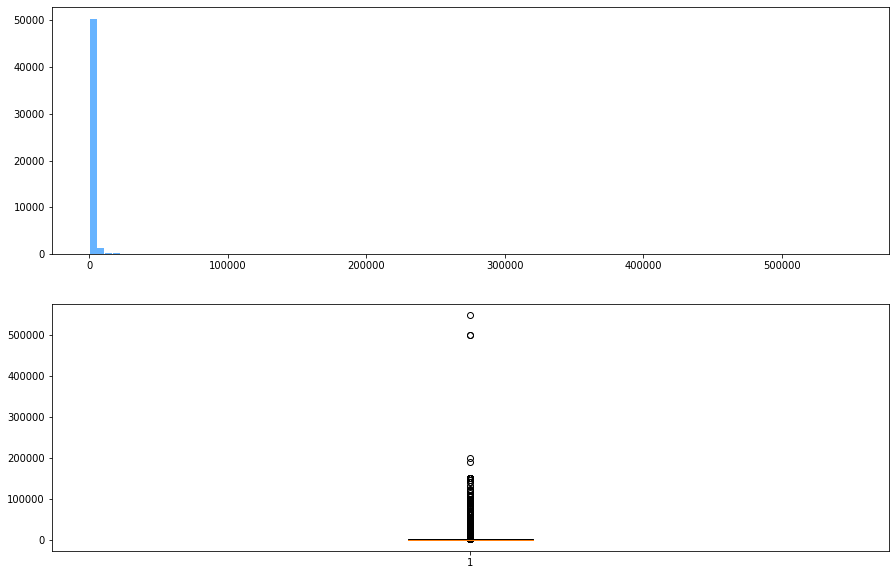

In [ ]:
df = Customers_DF[{'settledAt' , 'amount'}].loc[ (Customers_DF['status'] == 'SUCCESS' ) &  (Customers_DF['type'] == 'deposit')].groupby('settledAt').mean()

f, (fig1, fig2) = plt.subplots(2,1, sharex=False, figsize=(15, 10))

fig1.hist( df['amount'] , rwidth=0.9 , bins=100 , color = '#66b3ff')
fig2.boxplot(df['amount'])

plt.show()

Boxplot and Histogram of the value of successful withdrawals:

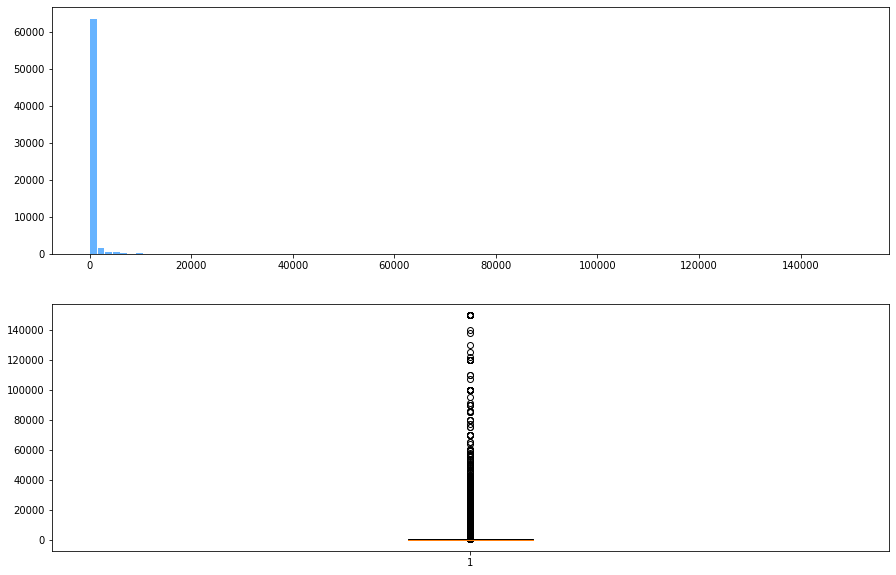

In [ ]:
df = Customers_DF[{'settledAt' , 'amount'}].loc[ (Customers_DF['status'] == 'SUCCESS' ) &  (Customers_DF['type'] == 'withdrawal')].groupby('settledAt').mean()

f, (fig1, fig2) = plt.subplots(2,1, sharex=False, figsize=(15, 10))

fig1.hist( df['amount'] , rwidth=0.9 , bins=100 , color = '#66b3ff')
fig2.boxplot(df['amount'])

plt.show()

As the plots illustrate, most transactions consist of small amounts ( around zero ). Moreover, there is a clear presence of outliers as well.

We will plot the time series of the mean of the succesfull transactions, one for type = deposit and one for type = withdrawal.

In [ ]:
# Type = deposit

df = Customers_DF[{'settledAt' , 'amount'}].loc[ (Customers_DF['status'] == 'SUCCESS' ) &  (Customers_DF['type'] == 'deposit')].groupby('settledAt').mean()
fig = px.line(df, x = df.index, y='amount')
fig.show()

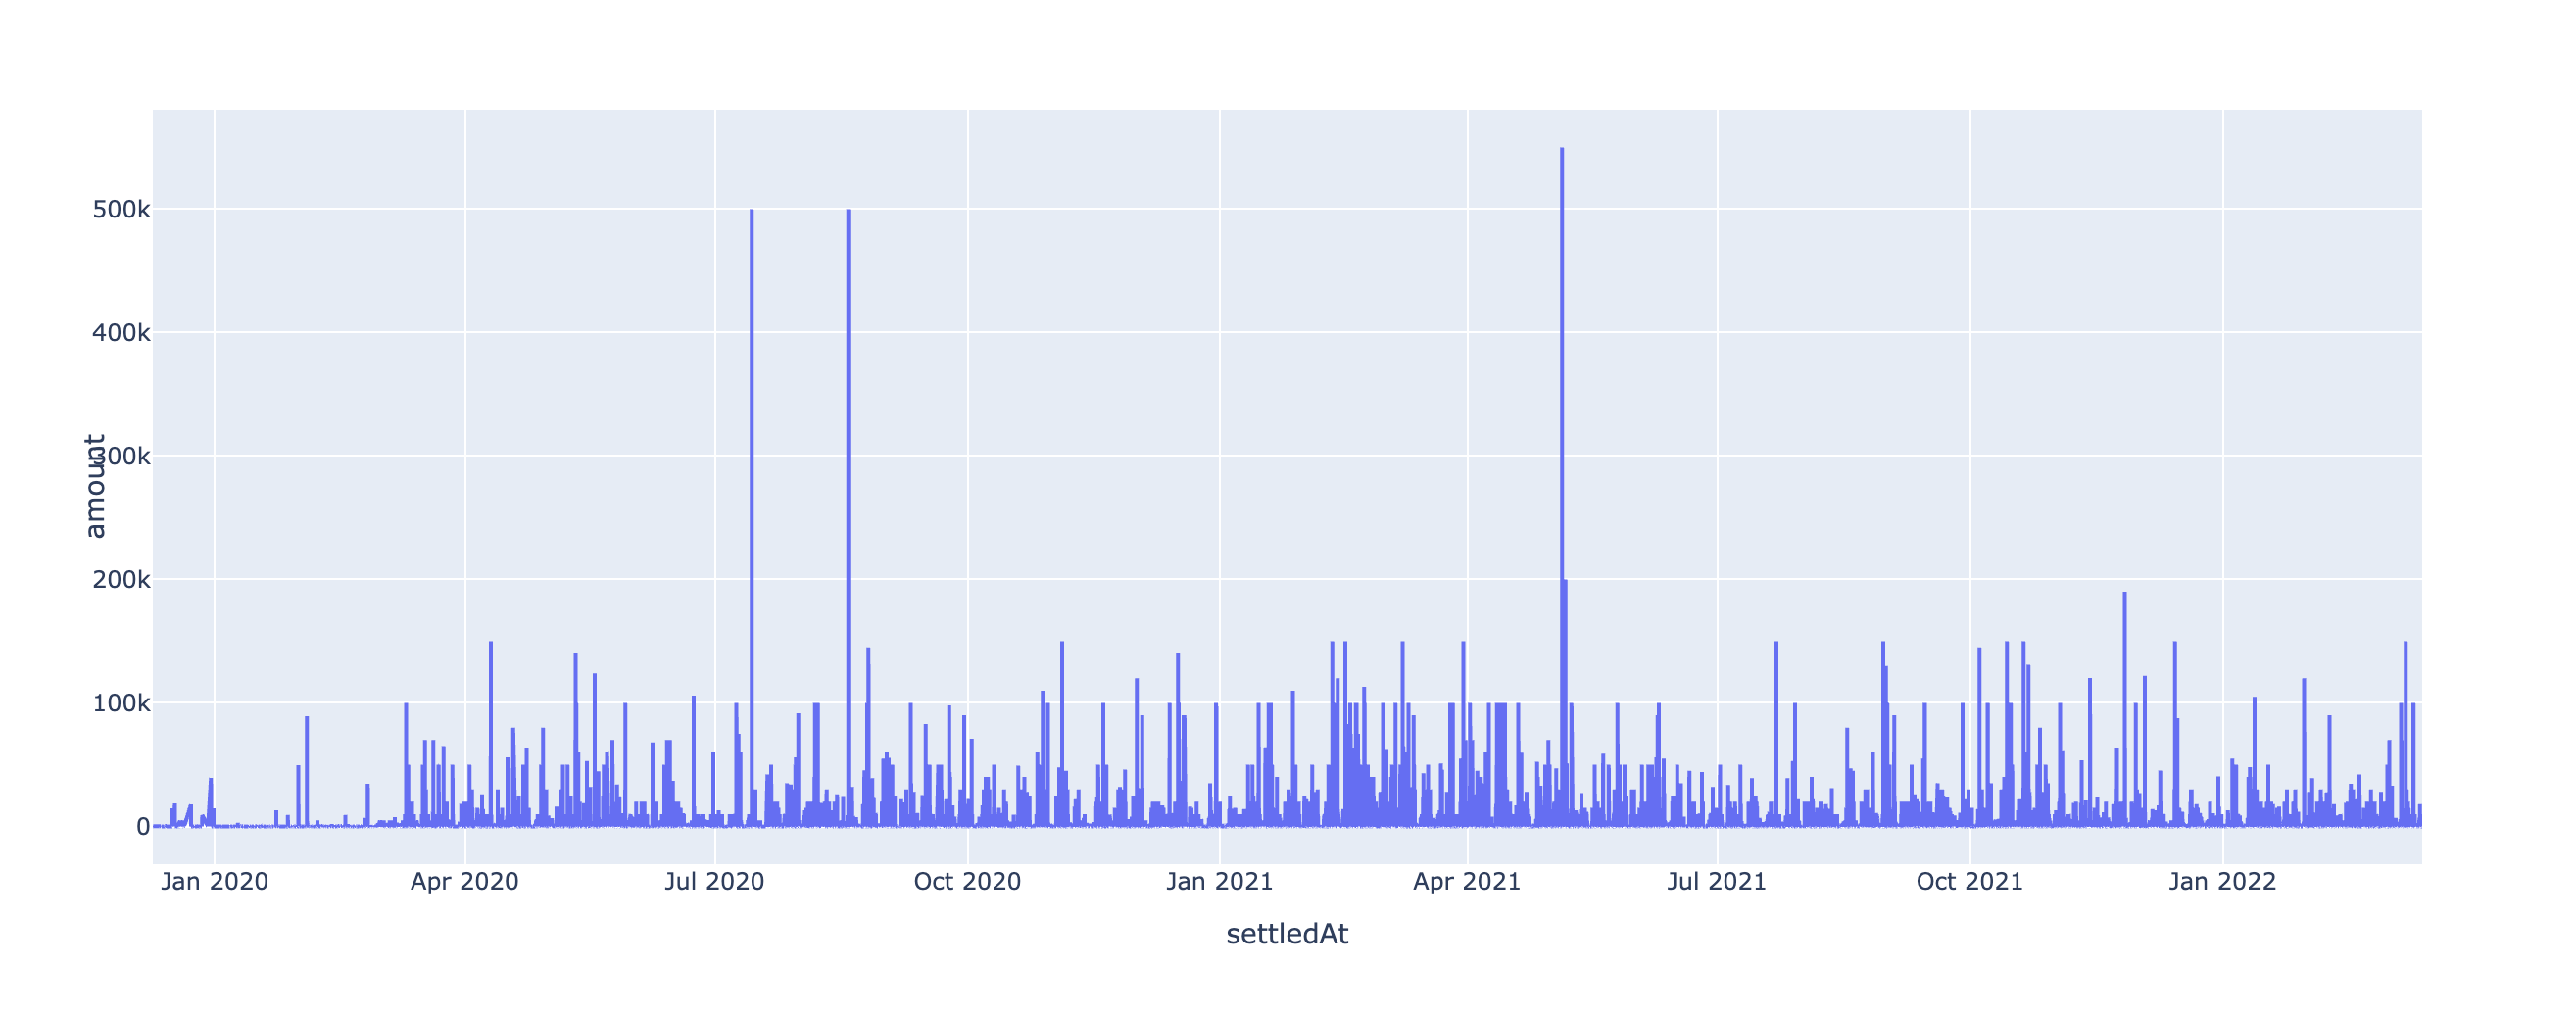

From the time series, it is visible that although from January 2020 to April 2020 there is a decrease in number as well as the amount of transaction, after this time period transactions do not present any flactuations other than normal. Furthermore, the presence of occational outliers is clear, however no specific pattern can be extracted.

In [ ]:
# Type = withdrawal

df = Customers_DF[{'settledAt' , 'amount'}].loc[ (Customers_DF['status'] == 'SUCCESS' ) &  (Customers_DF['type'] == 'withdrawal' )].groupby('settledAt').mean()
fig = px.line(df, x = df.index, y='amount')
fig.show()

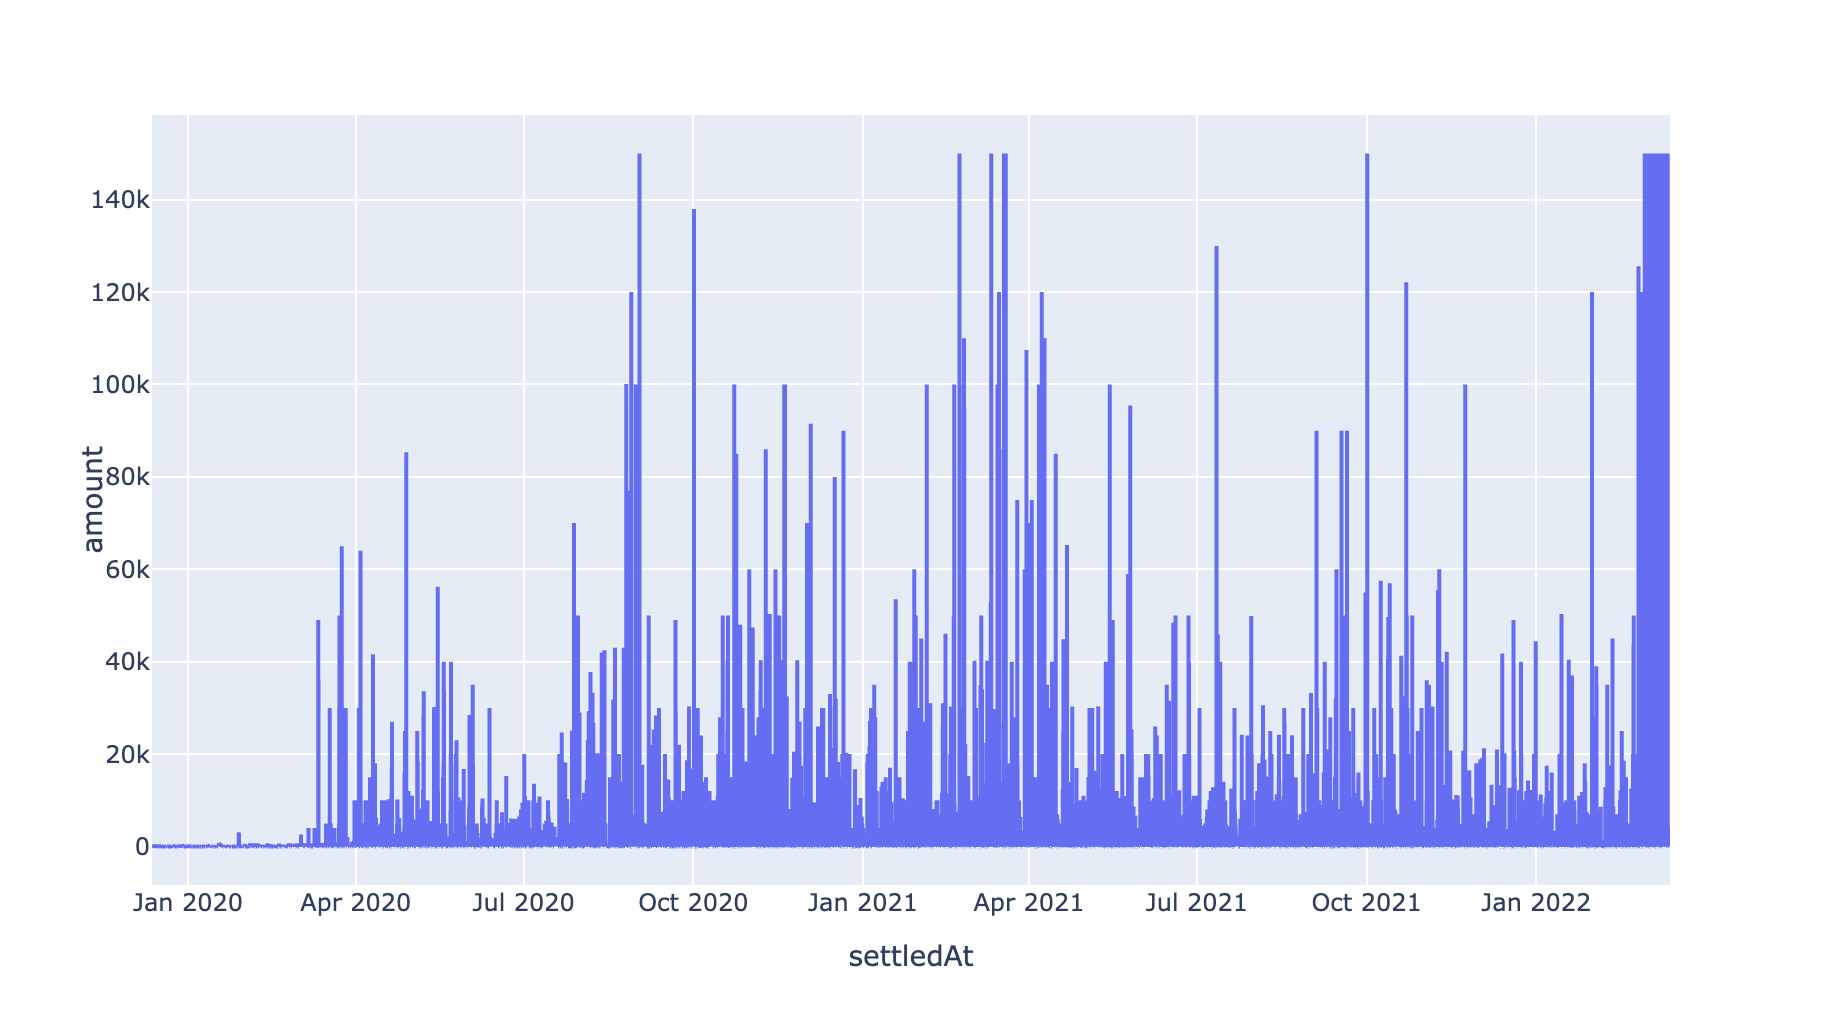

From the time series for the withdrawal transactions, we can see as well that from January 2020 until April 2020 there is a decline in the numbers and amounts of transactions. After that period, we can say that March is the month with the most withdrawals, however not there is not much data to verify that. Lastly, there is no presence of large amounts of withdrawals, like deposit transactions.

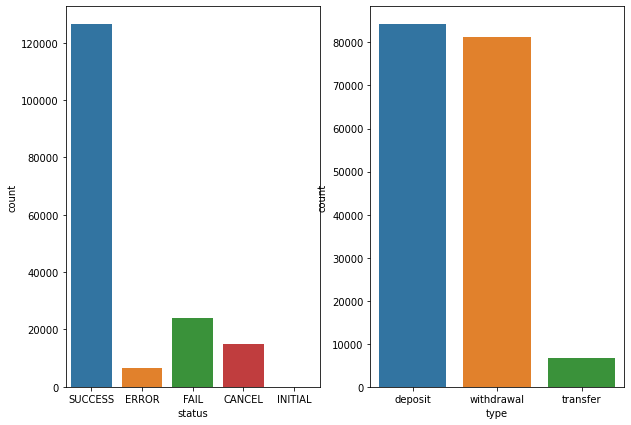

In [ ]:
i = 1
plt.figure(figsize=(10, 7))
for feature in ['status' , 'type']:
        plt.subplot(1,2,i)
        sns.countplot(x = feature, data = Customers_DF)
        i += 1
        if i==3 :
            break

The countplots show that most transactions were successful with almost equal amounts of deposits and withdrawals.

## Data preprocessing part 2

We will convert the categorical columns 'status' and 'type', to numeric. For the Status column, we will replace 'SUCCESS' with 1 and  'ERROR', 'FAIL', 'CANCEL', 'INITIAL' with zero. Moreover, for the Type column, we will replace 'deposit' with 1, 'withdrawal' with -1, and 'transfer' with 0.

In [ ]:
Dict1 = {'SUCCESS' : 1 , 'ERROR' : 0 , 'FAIL' : 0 , 'CANCEL' : 0 , 'INITIAL' : 0 }
Dict2 = {'deposit' : 1 , 'withdrawal' : -1 , 'transfer' : 0}

cleanup_nums = {'status': Dict1 , 'type' : Dict2 }

Customers_DF  = Customers_DF.replace(cleanup_nums)
Customers_DF.head()

,id,settledAt,ftd,amount,status,type
0,5774.0,2019-12-09 10:05:27.783000+00:00,1,50.0,1,1
1,5774.0,2019-12-15 20:09:26.286000+00:00,0,50.0,0,-1
2,5774.0,2019-12-16 06:49:49.786000+00:00,0,50.0,1,-1
3,5825.0,2020-03-23 08:48:32.463000+00:00,1,20.0,1,1
4,5825.0,2020-03-23 09:31:08.219000+00:00,0,20.0,0,1


By replacing the upper string variables with numbers, it enables us the ability to calculate each customer's revenue by transaction. For the calculation of each customer's revenue by transaction, we will simply multiply the columns 'amount', 'status', and 'type', and save the results in a column named 'transaction_value'.


In [ ]:
transaction_value = Customers_DF['amount'] * Customers_DF['status'] * Customers_DF['type']
Customers_DF['transaction_value'] = transaction_value

In [ ]:
Customers_DF.head()

,id,settledAt,ftd,amount,status,type,transaction_value
0,5774.0,2019-12-09 10:05:27.783000+00:00,1,50.0,1,1,50.0
1,5774.0,2019-12-15 20:09:26.286000+00:00,0,50.0,0,-1,-0.0
2,5774.0,2019-12-16 06:49:49.786000+00:00,0,50.0,1,-1,-50.0
3,5825.0,2020-03-23 08:48:32.463000+00:00,1,20.0,1,1,20.0
4,5825.0,2020-03-23 09:31:08.219000+00:00,0,20.0,0,1,0.0


In addition, it's clear that the dataframe contain rows with unsuccesfull transactions that do not contribute in the analysis. Therefore, we will drop all the rows where status is equal to zero. Furthermore, we will drop the columns 'status', 'amount', 'ftd' and 'type' as we does not need them anymore.

In [ ]:
Customers_DF2 = Customers_DF.drop( Customers_DF[ Customers_DF['status'] == 0 ].index)
Customers_DF2.drop(['status', 'amount' , 'ftd' , 'type'] , axis = 1 , inplace = True)

Customers_DF2

,id,settledAt,transaction_value
0,5774.0,2019-12-09 10:05:27.783000+00:00,50.0
2,5774.0,2019-12-16 06:49:49.786000+00:00,-50.0
3,5825.0,2020-03-23 08:48:32.463000+00:00,20.0
5,5825.0,2020-03-23 13:15:44.117000+00:00,-6.0
6,5825.0,2020-03-26 09:52:46.377000+00:00,20.0
...,...,...,...
171934,128797.0,2022-03-10 08:40:27.015000+00:00,100.0
171935,128850.0,2022-03-10 11:06:32.510000+00:00,159.0
171937,128853.0,2022-03-10 09:55:57.469000+00:00,50.0
171938,128853.0,2022-03-10 11:30:45.292000+00:00,50.0


# Calculating Customer Metrics:

After preprocessing the data, we will turn our raw transactional data into the metrics: frequency, recency, tenure (T) and  monetary_value, that we need to provide to the CLV models. For this, we will utilise the summary_data_from_transaction_data() from the lifetimes library.

**Frequency:** The number of orders a customer has placed

**Tenure:** How long a given customer has been with the company

**Recency:** How long it’s been since the customer’s last purchase

**Monetary value:** The average value of a given customer’s purchases.



In [ ]:
Metrics_DF = ( lifetimes.utils.summary_data_from_transaction_data(
    Customers_DF2,
    customer_id_col='id',
    datetime_col='settledAt',
    observation_period_end = Customers_DF2['settledAt'].max(), # setting as the end of the observation period the DateTime of the last transaction
    freq='h', #Hour - it will average transaction value by hour before calculating the final average transaction value
    monetary_value_col= 'transaction_value',
    include_first_transaction = True # So that the first transaction of each customer to be included in the metrics
    ))


Metrics_DF.head(10)

,frequency,recency,T,monetary_value
id,,,,
5774.0,2.0,164.0,19826.0,0.000000
5825.0,3.0,73.0,17308.0,11.333333
5830.0,1.0,0.0,16948.0,100.000000
5838.0,23.0,9051.0,18964.0,26.575217
5839.0,19.0,4175.0,19758.0,33.000000
5842.0,2.0,839.0,18769.0,0.000000
5848.0,1.0,0.0,19754.0,40.000000
5852.0,12.0,5269.0,18112.0,-7.620000
5857.0,10.0,7403.0,8721.0,2458.200000


In [ ]:
Positives = Metrics_DF.loc[Metrics_DF["monetary_value"] > 0 ,  ['monetary_value'] ].count()
Negatives = Metrics_DF.loc[Metrics_DF["monetary_value"] <= 0 ,  ['monetary_value'] ].count()
Zeros = Metrics_DF.loc[Metrics_DF["monetary_value"] == 0 ,  ['monetary_value'] ].count()

In [ ]:
print(f'The positive revenue counts are {Positives[0]} , the negative revenue counts are {Negatives[0]} and the count of zero revenues are {Zeros[0]}')

The positive revenue counts are 5687 , the negative revenue counts are 974 and the count of zero revenues are 529


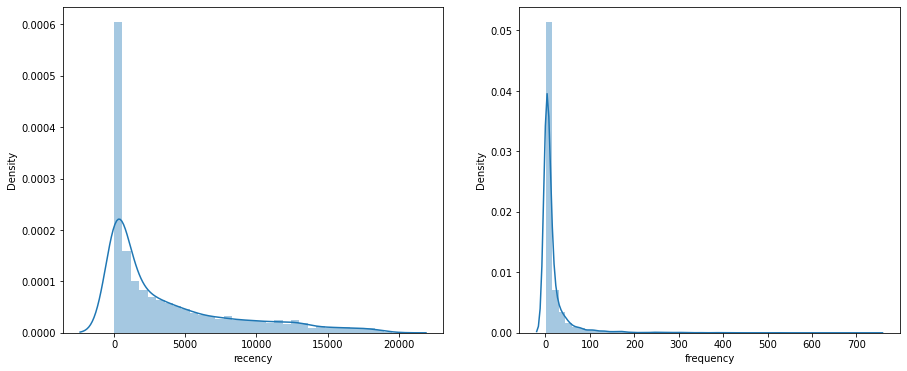

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.distplot(Metrics_DF['recency'])
plt.subplot(1,2,2)
sns.distplot(Metrics_DF['frequency'])

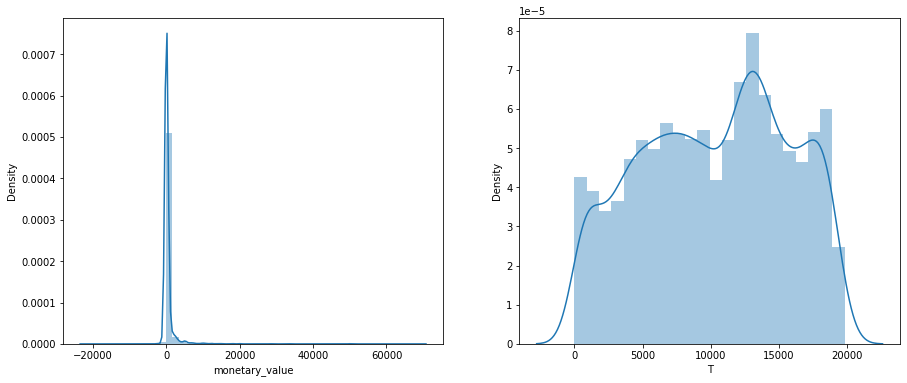

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.distplot(Metrics_DF['monetary_value'])
plt.subplot(1,2,2)
sns.distplot(Metrics_DF['T'])

As we can observe, most customers have placed a small amount of low-value orders, as monetary value as well as frequency, are distributed around zero and only a few customers had placed higher-value transactions. Furthermore, we can see a small decline in new customers as the tenure rates near zero are lower.

Now that we have generated the necessary statistics, we will proceed with modeling CLV. It is known that the Customer's Lifetime Value is equal to the expected number of transactions multiplied by the expected average profit, hence we will use 2 separate models. We will use the BG-NBD model, to predict the expected number of transactions a customer will make in a future period and the Linear Regression model to predict the expected average value of future transactions.

Following *Pareto's Principle*, '80% of the effect comes from 20% of the causes'. Its application to this business problem results in the assumption that only 20% of customers' purchases contribute to 80% of the firm's revenue. Therefore, apart from just modeling the Customer's Lifetime Value, we have to investigate further the behavior of the consumers. This will be achieved by plotting the results of BG-NBD and Gamma Gamma and performing the necessary data analytics.

# Modeling CLV

## BG-NBD

Beta Geometric / Negative Binomial Distribution, known as BG-NBD Model, will model each customer’s purchase behaviors’ distribution and will predict the expected number of transactions for each consumer for a future period.

This model has the following assumptions:

* Each individual, i, has a hidden lambda_i and p_i parameter
* These come from a population wide Gamma and a Beta distribution respectively.
* Individuals purchases follow a Poisson process with rate lambda_i*t .
* After each purchase, an individual has a p_i probability of dieing (never buying again).

Why use the BG-NBD over any regression model? The BG-NBD model calculates the probability of whether a customer is active or not, in contrast with any regression model. Regression models average past transaction data and conclude that the same number of purchases will occur in the future regardless if the customer is a churn or not, which fails the logic that surrounds the business-wise point of view.

###Fitting the BG-NBD model on data from the summary_data_from_transaction_data  function

In [ ]:
bgf = BetaGeoFitter(penalizer_coef=0)
# Fitting the data into the BG-NBD model
bgf.fit(Metrics_DF['frequency'], Metrics_DF['recency'], Metrics_DF['T'])

<lifetimes.BetaGeoFitter: fitted with 6661 subjects, a: 0.67, alpha: 80.53, b: 3.37, r: 0.83>

### F/R Matrix Visualization:

The BG-NBD model will get as input the frequency and recency and will output the F/R Matrix, a matrix with the expected number of purchases over the next time period. After that, we will visualize the results.

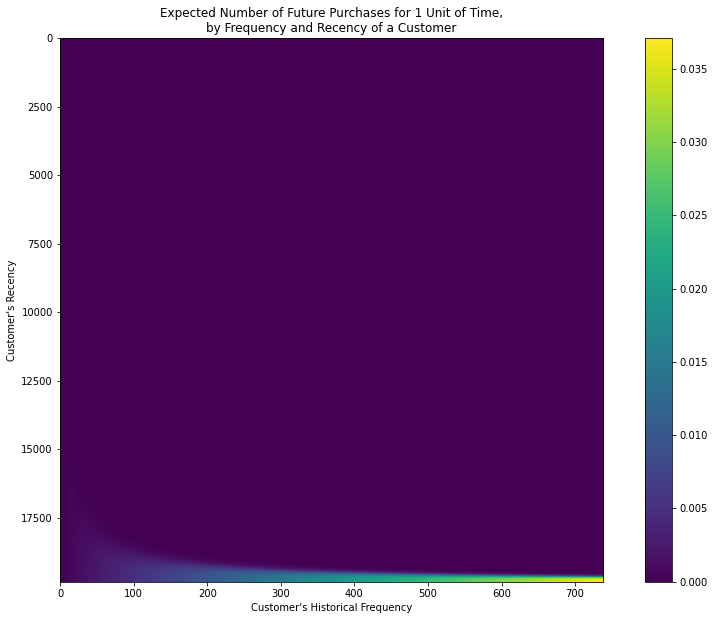

In [ ]:
plt.figure(figsize=(15, 10))
plot_frequency_recency_matrix(bgf)

From the heatmap above we can see that most customers are predicted to not purchase again, except from the customers with high frequency and recency.

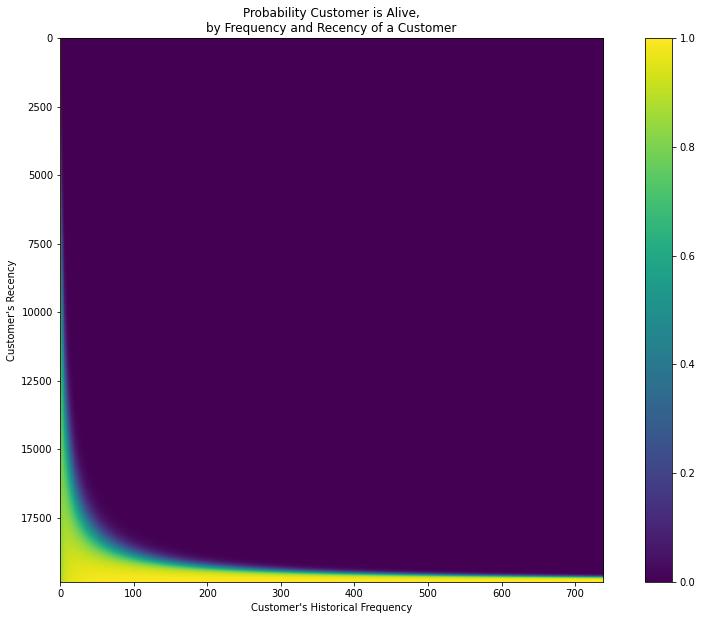

In [ ]:
plt.figure(figsize=(15 , 10))
plot_probability_alive_matrix(bgf)

It is visible that most customers are likely to not be active anymore, with only the exception of the customers who present high frequency and recency in transactions.

Conclusively, the consumers that are predicted to be active and to purchase again in the future are the customers with high frequency and recency.

### Calibration / Observation period

Because the data do not follow a poison distribution, it is expected that the model will lack some accuracy.

We will use the calibration_and_holdout_data function from the Lifetimes Library. This function splits the dataframe into a calibration and an observation period.The calibration period is used for training the model, and the observation period for testing it.

We will predict the expected number of transactions for the last 3 months. Therefore, the chosen calibration period starts from the date of the first transaction in the dataset and ends on 2021-12-31 23:49:13.857000+00:00. Immediately after this period the observation period starts, and ends on the DateTime of the last transaction.

In [ ]:
calibration_holdout_matrix = calibration_and_holdout_data( Customers_DF2,
                                                    customer_id_col = 'id',
                                                    datetime_col = 'settledAt',
                                                    calibration_period_end = '2021-12-31 23:49:13.857000+00:00',
                                                    observation_period_end= Customers_DF2['settledAt'].max(),  # setting as the end of the observation period the DateTime of the last transaction
                                                    freq='h', #Hour - it will average transaction value by hour before calculating the final average transaction value
                                                    monetary_value_col = 'transaction_value',
                                                    include_first_transaction = True  # So that the first transaction of each customer to be included in the metrics
                                                   )


In [ ]:
calibration_holdout_matrix

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
id,,,,,,,
5774.0,2.0,164.0,18085.0,0.000000,0.0,0.000,1741.0
5825.0,3.0,73.0,15567.0,11.333333,0.0,0.000,1741.0
5830.0,1.0,0.0,15207.0,100.000000,0.0,0.000,1741.0
5838.0,23.0,9051.0,17223.0,26.575217,0.0,0.000,1741.0
5839.0,19.0,4175.0,18017.0,33.000000,0.0,0.000,1741.0
...,...,...,...,...,...,...,...
116466.0,1.0,0.0,252.0,5000.000000,4.0,6900.000,1741.0
116536.0,1.0,0.0,205.0,20.000000,0.0,0.000,1741.0
116576.0,1.0,0.0,108.0,530.000000,8.0,-118.375,1741.0


Observation, calibration_holdout_matrix has 6180 rows out of the initial 6661, because it cropped out the new customers that appeared for the first time in the observation period.

### Fitting the BG-NBD model on data from the calibration_and_holdout_data  function

In [ ]:
bgf = BetaGeoFitter(penalizer_coef=0)
# Fitting the data into the BG-NBD model
bgf.fit(calibration_holdout_matrix['frequency_cal'],
        calibration_holdout_matrix['recency_cal'],
        calibration_holdout_matrix['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 6180 subjects, a: 0.71, alpha: 80.09, b: 3.50, r: 0.84>

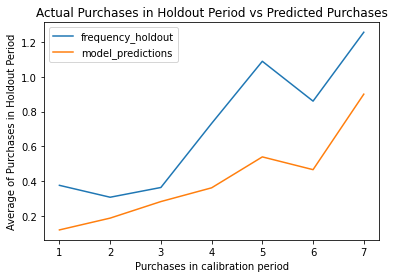

In [ ]:
plot_calibration_purchases_vs_holdout_purchases(bgf, calibration_holdout_matrix)

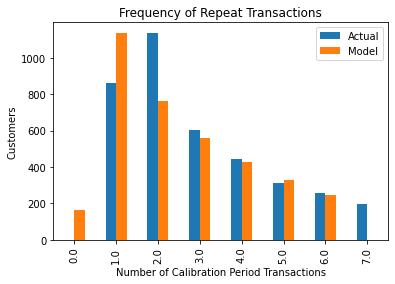

In [ ]:
plot_period_transactions(bgf)

As expected, the model is a mediocre one.

### Prediction of Customers Purchases Analysis

Now, we will predict the customer's 5838 expected number of future purchases in the next 3 months, after the end of the calibration period.

In [ ]:
t = 2160 # 2160 hours is aproximatetly 3 months
Customer_5838 = calibration_holdout_matrix.iloc[3]

bgf.predict(t, Customer_5838['frequency_cal'], Customer_5838['recency_cal'], Customer_5838['T_cal'] )

2.455095854076855e-05

As we can see, the expected number of transactions is near zero. However, why is this happening? We will investigate further with the function plot_history_alive from the Lifetimes Library, which plots the probability of a customer being alive. We will plot the behavior of the customer with id 5838, again in the 3-month future period.

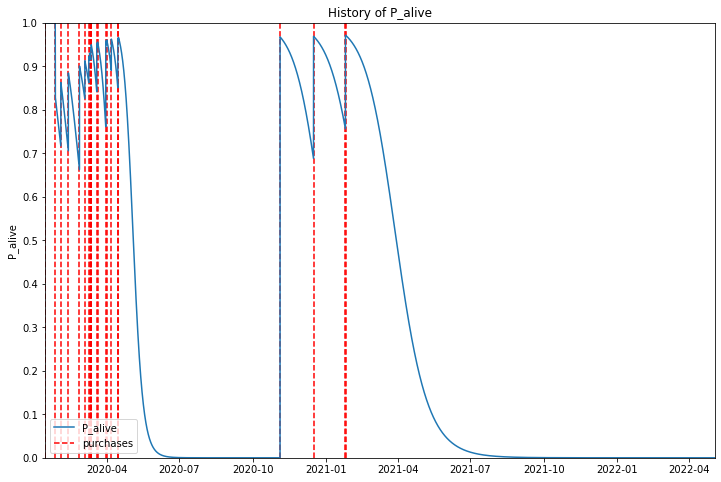

In [ ]:
plt.figure(figsize=(12 , 8))
plot_history_alive(bgf, 20160 ,Customers_DF2.loc[Customers_DF2['id'] == 5838] , 'settledAt' , freq='h')

From the line plot, we can see that the probability decreases rapidly between periods of inactivity. For this reason, because of the inactivity that occurred after the customer's 5838 last transactions, the model dropped its probability of being active near zero, hence, the predicted zero future transactions in the next period.

The next step is to predict the expected number of purchases each customer will make from the end of the calibration period until the end of the observation period and save the results.

In [ ]:
from datetime import datetime

start_time = datetime.strptime('2021-12-31 23:49:13.857000', '%Y-%m-%d %H:%M:%S.%f')  # End of calibration period
end_time = datetime.strptime('2022-03-14 12:26:02.236000', '%Y-%m-%d %H:%M:%S.%f') # End of observation period

# get difference
delta = end_time - start_time
sec = delta.total_seconds()

hours = sec / (60 * 60)
print('difference in hours:', hours)

difference in hours: 1740.613438611111


In [ ]:
t = 1740.613438611111 # 1740.613438611111 hours from the calibration period until the end of the observation period

Expected_number_of_transactions = bgf.predict(t, calibration_holdout_matrix['frequency_cal'], calibration_holdout_matrix['recency_cal'], calibration_holdout_matrix['T_cal'] )
Expected_number_of_transactions = pd.DataFrame(Expected_number_of_transactions , columns = ['Expected number of transactions'])
Expected_number_of_transactions = Expected_number_of_transactions.sort_values(by = 'Expected number of transactions' , ascending=False)

In [ ]:
Expected_number_of_transactions

,Expected number of transactions
id,
111399.0,8.314757e+01
44231.0,7.506898e+01
47515.0,6.724275e+01
14129.0,6.306945e+01
66813.0,6.292902e+01
...,...
30050.0,7.006778e-61
8595.0,4.369354e-64
49720.0,5.484344e-66


# Linear Regression Model

After predicting each customer's expected number of purchases, we will use the Linear Regression model to predict the expected transaction value each customer will purchase in the next time period.

For the Linear regression model, we will initially have to do some data preprocessing. After dropping the customers that made their first appearance in the last 3-month period, we will generate the RFM matrix manually, and afterward, we will compartmentalize the data into 3-month period chunks and take the last chunk as the target for predictions. After the data modification, we will fit the model and predict each customer's average revenue for the last 3-month period ( 2021/12/31 end of calibration period - 2022/3/10 end of the observation period). Lastly, we will assess the model using the R-Squared, which is a statistical measure of fit that indicates how much variation of a dependent variable is explained by the independent variable(s) in a regression model.

## Data Preprocessing part 3

### Creating the RFM Matrix manually

In [ ]:
Customers_DF3 = Customers_DF2.copy()

We will create a new column, that will assign each row to its chunk. C_1 is the first 3-month period of the dataset and C_10 is the last.

In [ ]:
def mean(x):
    return x.mean()

def frequency(x):
    return x.count()

def recency(x):
    return (x.max() - x.min()).days


freq = '3M'
RFM = Customers_DF3.groupby([ 'id',  pd.Grouper(key='settledAt', freq= freq) ]).agg({'transaction_value': [mean , frequency],
                                                                                    'settledAt': [recency]})
RFM.columns = ['_'.join(col).lower() for col in RFM.columns]
RFM.rename(columns = {'transaction_value_mean':'Monetary Value'}, inplace = True)
RFM.rename(columns = {'transaction_value_frequency':'Frequency'}, inplace = True)
RFM.rename(columns = {'settledat_recency':'Recency'}, inplace = True)
RFM = RFM.reset_index()
map_date_month = {str(x)[:10]: 'C_%s' % (i+1) for i, x in enumerate( sorted(RFM.reset_index()['settledAt'].unique(), reverse=False))}

RFM['Chunks'] = RFM['settledAt'].apply(lambda x: map_date_month[str(x)[:10]])

In [ ]:
map_date_month

{'2019-12-31': 'C_1',
 '2020-03-31': 'C_2',
 '2020-06-30': 'C_3',
 '2020-09-30': 'C_4',
 '2020-12-31': 'C_5',
 '2021-03-31': 'C_6',
 '2021-06-30': 'C_7',
 '2021-09-30': 'C_8',
 '2021-12-31': 'C_9',
 '2022-03-31': 'C_10'}

In [ ]:
RFM.head()

,id,settledAt,Monetary Value,Frequency,Recency,Chunks
0,5774.0,2019-12-31 00:00:00+00:00,0.000000,2,6,C_1
1,5825.0,2020-03-31 00:00:00+00:00,11.333333,3,3,C_2
2,5830.0,2020-06-30 00:00:00+00:00,100.000000,1,0,C_3
3,5838.0,2020-03-31 00:00:00+00:00,27.781250,16,77,C_2
4,5838.0,2020-06-30 00:00:00+00:00,14.000000,3,8,C_3


Compartmentalizing the data into 3-month period chunks.

In [ ]:
Customers_DF3 = pd.pivot_table( RFM, values=['Monetary Value'], columns='Chunks', index='id')

Customers_DF3.reset_index()
Customers_DF3.columns = ['_'.join(col) for col in Customers_DF3.columns]

Customers_DF3.fillna(0, inplace=True)

In [ ]:
Customers_DF3

,Monetary Value_C_1,Monetary Value_C_10,Monetary Value_C_2,Monetary Value_C_3,Monetary Value_C_4,Monetary Value_C_5,Monetary Value_C_6,Monetary Value_C_7,Monetary Value_C_8,Monetary Value_C_9
id,,,,,,,,,,
5774.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0
5825.0,0.0,0.0,11.333333,0.0,0.0,0.0,0.000,0.0,0.0,0.0
5830.0,0.0,0.0,0.000000,100.0,0.0,0.0,0.000,0.0,0.0,0.0
5838.0,0.0,0.0,27.781250,14.0,0.0,49.0,13.365,0.0,0.0,0.0
5839.0,44.7,0.0,8.333333,10.0,0.0,0.0,0.000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
128786.0,0.0,70.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0
128797.0,0.0,100.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0
128850.0,0.0,159.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0


We want only the customers that purchased for the first time before the start of the observation period, hence we will drop any new customers that made their appearance after 2021-12-31 23:49:13.857000+00:00, which is the end of the calibration period.

In [ ]:
Customers_DF3.drop(Customers_DF3.drop( calibration_holdout_matrix.index , inplace = False).index , inplace = True)

In [ ]:
Customers_DF3.shape

(6180, 10)

To summarise, for the data processing for the Linear Regression model, we have computed a matrix in which each row represents the average transactions every 3-month period each customer made.

## Creating the Calibration and Observation period

In [ ]:
Testing = Customers_DF3[{'Monetary Value_C_10'}]
Training = Customers_DF3.drop(['Monetary Value_C_10'] , axis = 1)

In [ ]:
Y_train = Training['Monetary Value_C_9']
X_train = Training.drop(['Monetary Value_C_9'] , axis = 1)

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

LinearRegression()

In [ ]:
Predictions =  lin_reg.predict(X_train)

## Predictions Vs Actual Data

R-squared for training:

In [ ]:
r2_score( Y_train , Predictions )

0.004811973054991037

R-squared for testing:

In [ ]:
Predictions_2 =  lin_reg.predict(Training.drop(['Monetary Value_C_1'] , axis = 1))

In [ ]:
r2_score( Testing , Predictions_2)

-0.06869748880062954

The R-squared scores are different for train and test data, thus there is some potential overfitting/underfitting. In addition, knowing that the R-squared ranges from 0 to 1, and for the last 3-month period prediction's assessment, the value was negative, we can conclude that the model performed extremely badly. Nevertheless, we will continue with the calculation of CLV.

The next step is to predict the expected value of purchases each customer will make from the end of the calibration period until the end of the observation period and save the results.

In [ ]:
Expected_value_of_purchases = Testing.copy()
Expected_value_of_purchases['Monetary Value_C_10'] = Predictions_2
Expected_value_of_purchases.rename(columns = {'Monetary Value_C_10' : 'Expected value of purchases'}, inplace = True)

In [ ]:
Expected_value_of_purchases

,Expected value of purchases
id,
5774.0,101.531454
5825.0,101.468049
5830.0,101.320309
5838.0,103.000000
5839.0,101.463718
...,...
116466.0,665.999763
116536.0,103.789328
116576.0,161.365095


Except for Linear Regression, Gamma-Gamma is another model that can predict each customer's expected value of transactions. However, it takes as input only positive monetary values. Nevertheless, we will still use Gamma-Gamma for the prediction as well as for data analysis purposes.

# Gamma-Gamma Model

We will fit the model with the calibration_holdout_matrix Data. However, we must investigate the correlation between monetary value and frequency, because the model relies upon the assumption that there is no relation between them

In [ ]:
calibration_holdout_matrix[['monetary_value_cal', 'frequency_cal']].corr()

,monetary_value_cal,frequency_cal
monetary_value_cal,1.000000,-0.029401
frequency_cal,-0.029401,1.000000


Because the two have no correlation we can proceed with fitting the data to the model

In this step, we have to drop the rows that have monetary values <= 0, because the gamma gamma model can only input positive monetary values.

In [ ]:
Data = calibration_holdout_matrix.loc[ calibration_holdout_matrix["monetary_value_cal"] > 0 ].copy()

In [ ]:
Data

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
id,,,,,,,
5825.0,3.0,73.0,15567.0,11.333333,0.0,0.000,1741.0
5830.0,1.0,0.0,15207.0,100.000000,0.0,0.000,1741.0
5838.0,23.0,9051.0,17223.0,26.575217,0.0,0.000,1741.0
5839.0,19.0,4175.0,18017.0,33.000000,0.0,0.000,1741.0
5848.0,1.0,0.0,18013.0,40.000000,0.0,0.000,1741.0
...,...,...,...,...,...,...,...
116466.0,1.0,0.0,252.0,5000.000000,4.0,6900.000,1741.0
116536.0,1.0,0.0,205.0,20.000000,0.0,0.000,1741.0
116576.0,1.0,0.0,108.0,530.000000,8.0,-118.375,1741.0


In [ ]:
calibration_holdout_matrix.shape[0] - Data.shape[0]

899

### Fitting the data to the Gamma-Gamma Model

In [ ]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(Data["frequency_cal"], Data["monetary_value_cal"])

<lifetimes.GammaGammaFitter: fitted with 5281 subjects, p: 0.81, q: 0.33, v: 2.12>

### Average Order Value

Now we will predict customer's expected purchase value - AOV

In [ ]:
AOV = ggf.conditional_expected_average_profit(
        Data['frequency_cal'],
        Data['monetary_value_cal'])

In [ ]:
AOV_DF = pd.DataFrame(AOV , columns = ['AOV'])
AOV_DF.head()

,AOV
id,
5825.0,16.661400
5830.0,608.029536
5838.0,27.668370
5839.0,34.628068
5848.0,250.789423


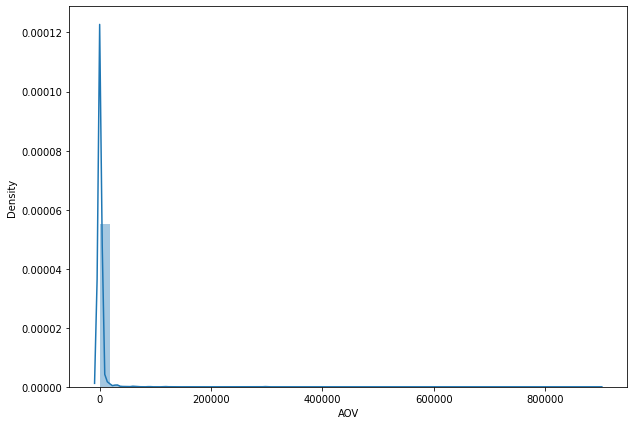

In [ ]:
plt.figure(figsize=(10 , 7))
sns.distplot(AOV_DF['AOV'])

Most of the customers are expected to end up with only small average transactions, but there exists a long tail of higher-value customers.

Moreover, we will apply K-means clustering to the AOV dataframe so we can analyze further the differences in average transactions and get a better picture of the data.

In [ ]:
clusters = AOV_DF[['AOV']]
kmeans = KMeans(n_clusters = 5)
kmeans.fit(clusters)

clusters = clusters.assign(cluster=kmeans.labels_)
clusters.groupby('cluster')['AOV'].mean().sort_values(ascending=False).to_frame()

,AOV
cluster,
2,893112.911934
1,285804.719775
3,83831.874952
4,21761.185635
0,398.262143


In [ ]:
clusters.groupby('cluster').count()

,AOV
cluster,
0,5135
1,6
2,1
3,19
4,120


Clusters 2 and 1 contain customers who are predicted to be high spenders with an average order value of 893113 and 285805 respectively. Cluster 0, which contains 97% of the firm's customers, holds the low spenders, with an average order value of 398.

# Predicting Customer Lifetime Value

## CLV with Gamma-Gamma

We will use both models to predict the CLV, BG-NBD model to predict the number of orders and the Gamma Gamma model to predict their values.

In [ ]:
CLV_gg = ggf.customer_lifetime_value(
    bgf,
    Data['frequency_cal'],
    Data['recency_cal'],
    Data['T_cal'],
    Data['monetary_value_cal'],
    time = 2.3 # the lifetime expected for the user in months
)

CLV_gg = CLV_gg.to_frame().reset_index()
CLV_gg = CLV_gg.sort_values(by='clv', ascending=False)

In [ ]:
CLV_gg

,id,clv
5160,113157.0,4.041028e+04
5244,115348.0,2.649742e+04
2073,41433.0,9.451518e+03
2085,41692.0,9.055432e+03
4416,97605.0,5.804484e+03
...,...,...
890,15484.0,1.778096e-55
824,14863.0,1.948409e-58
1655,30050.0,7.694391e-63
242,8595.0,5.523658e-64


## CLV with Linear Regression

In [ ]:
Expected_number_of_transactions

,Expected number of transactions
id,
111399.0,8.314757e+01
44231.0,7.506898e+01
47515.0,6.724275e+01
14129.0,6.306945e+01
66813.0,6.292902e+01
...,...
30050.0,7.006778e-61
8595.0,4.369354e-64
49720.0,5.484344e-66


In [ ]:
Expected_value_of_purchases

,Expected value of purchases
id,
5774.0,101.531454
5825.0,101.468049
5830.0,101.320309
5838.0,103.000000
5839.0,101.463718
...,...
116466.0,665.999763
116536.0,103.789328
116576.0,161.365095


In [ ]:
CLV_pred = Expected_number_of_transactions['Expected number of transactions'] * Expected_value_of_purchases['Expected value of purchases']
CLV_pred = CLV_pred.to_frame().reset_index()
CLV_pred.rename(columns = { 0 : 'CLV' }, inplace = True)
CLV_pred

,id,CLV
0,5774.0,8.101464e-04
1,5825.0,6.130590e-06
2,5830.0,6.338253e-03
3,5838.0,2.052730e-03
4,5839.0,1.889814e-09
...,...,...
6175,116466.0,9.967531e+02
6176,116536.0,2.101241e+02
6177,116576.0,6.699984e+02
6178,116712.0,1.121730e+03


## Calculation of the actual CLV

Now that we have predicted the Customer's Life Value over the last 3 months, we will compute the actual CLV for the model's assessment.

In [ ]:
Customers_DF4 = pd.pivot_table( RFM, values=['Monetary Value' , 'Frequency'], columns='Chunks', index='id')

Customers_DF4.reset_index()
Customers_DF4.columns = ['_'.join(col) for col in Customers_DF4.columns]

Customers_DF4.fillna(0, inplace=True)
Customers_DF4.drop(Customers_DF4.drop( calibration_holdout_matrix.index , inplace = False).index , inplace = True)

In [ ]:
CLV = Customers_DF4['Frequency_C_10'] * Customers_DF4['Monetary Value_C_10']
CLV = CLV.to_frame().reset_index()
CLV.rename(columns = { 0 : 'real_CLV' }, inplace = True)
CLV

,id,real_CLV
0,5774.0,0.0
1,5825.0,0.0
2,5830.0,0.0
3,5838.0,0.0
4,5839.0,0.0
...,...,...
6175,116466.0,27600.0
6176,116536.0,0.0
6177,116576.0,-947.0
6178,116712.0,0.0


Real CLV for the Gamma Gamma Model:

In [ ]:
calibration_holdout_matrix = calibration_holdout_matrix.loc[ calibration_holdout_matrix["monetary_value_cal"] > 0 ].copy()


CLV_GG = calibration_holdout_matrix['frequency_holdout']*calibration_holdout_matrix['monetary_value_holdout']
CLV_GG = CLV_GG.to_frame().reset_index()
CLV_GG.rename(columns = { 0 : 'real_CLV' }, inplace = True)
CLV_GG

,id,real_CLV
0,5825.0,0.0
1,5830.0,0.0
2,5838.0,0.0
3,5839.0,0.0
4,5848.0,0.0
...,...,...
5276,116466.0,27600.0
5277,116536.0,0.0
5278,116576.0,-947.0
5279,116712.0,0.0


# Predictions vs Actual CLV

## Evaluation of the model in terms of prediction error

For the assessment, we will use median absolute error, because is robust to outliers. The loss is calculated by taking the median of all absolute differences between the target and the prediction. The best value is 0.0.

### CLV with Linear Regression

In [ ]:
median_absolute_error( CLV['real_CLV'] , CLV_pred['CLV'] )

0.7163480402945213

Unfortunately, MedAE = 0.716 which is not near zero, hence the model did not predict CLV accurately.

### CLV with Gamma Gamma

In [ ]:
median_absolute_error( CLV_GG['real_CLV'] , CLV_gg['clv'] )

0.5154973899795913

The predicted Customer Lifetime Values for the remaining customers are better than Linear Regressions. Thus, the Gamma Gamma model in combination with the BG-NBD is more accurate.

## Business-oriented evaluation

We will assess the two models in terms of the best accuracy of the CLV of the highest-value consumers. We will use k-means to find the highest spenders.

In [ ]:
Clusters = CLV_GG[['real_CLV']]
kmeans = KMeans(n_clusters = 5)
kmeans.fit(Clusters)

Clusters = Clusters.assign(cluster=kmeans.labels_)
Clusters.groupby('cluster')['real_CLV'].mean().sort_values(ascending=False).to_frame()

,real_CLV
cluster,
1,286852.941176
2,79283.936502
4,21883.746947
0,63.831750
3,-125573.000000


In [ ]:
Clusters.groupby('cluster').count()

,real_CLV
cluster,
0,5238
1,2
2,7
3,1
4,33


Firstly, we will sort the actual CLV and take the first 42 consumers - the higher-value consumers. The number 42 came from the k-means clusters, excluding the clusters with the low spenders.

In [ ]:
High_Value_Customers_CLV = CLV_GG.sort_values('real_CLV' , ascending = False).head(42)

Now we will assess the models again, but first, we will extract the predicted CVs for the high-value customers.

In [ ]:
results = High_Value_Customers_CLV.merge(CLV_pred , on = 'id')
results.rename(columns = { 'CLV' : 'LR' }, inplace = True)
results = results.merge(CLV_gg , on = 'id')
results.rename(columns = { 'clv' : 'GG' }, inplace = True)

In [ ]:
results.head()

,id,real_CLV,LR,GG
0,55451.0,300000.000000,140.001065,40.023770
1,41692.0,273705.882353,52548.485467,9055.431696
2,65796.0,123450.000000,11706.244100,2591.935678
3,107886.0,95000.000000,1093.881282,373.887427
4,17380.0,86050.000000,11733.809938,2200.071341


Linear Regression:

In [ ]:
median_absolute_error( results['real_CLV'] , results['LR'] )

20716.9217965762

Gamma-Gamma:

In [ ]:
median_absolute_error( results['real_CLV'] , results['GG'] )

22022.03606044963

Although both results are very bad, Linear Regression predicted more accurately the higher value consumers, thus Linear Regression is the best model of the two.

# Summary

---


The task of this project was to model and predict the Customer's Lifetime Value, which can be calculated by the multiplication of transaction frequency and transaction average value. To achieve this, we firstly performed data preprocessing to our data so it could fit a certain format. For data preprocessing, we replaced boolean values of the 'ftd' column, performed NLP to the 'settledAt' column as well as changed its data type to DateTime, and also deleted any invalid transaction of the dataframe. Secondly, we computed the necessary metrics, like Frequency, Recency , Tenure and Monetary Value and then did Data Visualization and Analysis. From the analysis we concluded that most consumers purchased a single low value transaction. In addition, most customers are likely innactive and only the most frequent consumers with high recency are classified as still alive. Furthermore, the probability of a customer being churned increases rapidly the longer the customer stays inactive after its last transaction. Thirdly, we splitted the data based on calibration and observation periods, which is a similar process to the train-test split. After the split, we predicted the customers expected figure of transactions in the last 3-month period using the BG-NBD model. For the prediction of customers' expected value of purchases, we used two models, Gamma-Gamma and Linear Regression. Additionally,for the model assessment, the measure used was the median square error, which is a measure used for regression models and has the advantage of being resilient to outliers. The two approaches for evaluation were 1)evaluating the models according to prediction error, and 2) a business-oriented evaluation, where we took into account the prediction error of only the higher-value consumers. Lastly, both models had their pros and cons. The Gamma-Gamma model, although it is the more accurate one in terms of prediction error, cannot input any non-positive monetary value, and unfortunately, this does not apply to our case. On the other hand, Linear regression could predict any CLV and achieved the best accuracy business-wise. However, the two models are far near perfect as both are poorly assessed.

# Bibliography

https://practicaldatascience.co.uk/data-science/how-to-segment-customers-based-on-their-value-using-rfm-and-abc

https://www.kaggle.com/code/dddddddddd1/customer-lifetime-value-prediction-bg-nbd-model

https://lifetimes.readthedocs.io/en/latest/lifetimes.html#module-lifetimes.utils

https://lifetimes.readthedocs.io/en/latest/lifetimes.fitters.html

https://practicaldatascience.co.uk/data-science/how-to-calculate-clv-using-bgnbd-and-gamma-gamma

https://towardsdatascience.com/measuring-customers-value-using-python-lifetimes-d8b19a04e9c1

https://medium.com/swlh/predict-customer-lifetime-value-with-machine-learning-545624073d14

https://www.investopedia.com/terms/r/r-squared.asp

https://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error